# Short-term Temperature Model Test

## Import dependencies and data

In [10]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [11]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [144]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [145]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [146]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
state         TA01_output         15
              TA02_output         14
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  2
              gsi_deriv            2
              vol                  2
              vol_deriv            2
time          dayofyear            2
              monthofyear          2
              minofday             2
              hourofday      

In [147]:
# remove single NAN
data = data.dropna(how='any')

In [148]:
# # reduce to one OBS per MIN
data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

# remove APRIL data
# data = data[data.index.get_level_values(0) != 4]

## GH Temperature & Humidity

In [149]:
### create "better" estimate of temperature var, w. proper avg.
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [150]:
### create "better" estimate of temperature var, w. proper avg.
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

## Kalman filtering

In [151]:
cols = [
    (('temperatures', 'TA01_GT10X_GM10X'), 3),
    (('temperatures', 'DC_GT401_GM401'), 2),
    (('temperatures', 'TA01_GT401_GM401'), 3),
    (('temperatures', 'DC_GT301_damped'), 4),
    (('humidity', 'TA01_GT10X_GM10X'), 3),
    
]

for colSpec in cols:
    # apply KALMAN filter to measurements
    col = colSpec[0]
    varExp = colSpec[-1]
    
    # get data
    X = data[col].values
    n = len(X)

    # process variance, measurement variance
    Q = 1e-5
    R = 0.1**varExp

    xhat=np.zeros(n)      # a posteri estimate of x
    P=np.zeros(n)         # a posteri error estimate
    xhatminus=np.zeros(n) # a priori estimate of x
    Pminus=np.zeros(n)    # a priori error estimate
    K=np.zeros(n)         # gain or blending factor

    # intial guesses
    xhat[0] = X[0]
    P[0] = X[1]

    for k in range(1,n):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    data[col] = xhat

## Split into training / testing

In [152]:
# filter data by variables
model_vars = [
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('time', 'minofday'),
]

data = data[model_vars].copy()

In [153]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day']).count().index.values

# get number of days f. testing / training
train_frac = 0.9
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

del data

### Save split info

In [ ]:
print(days[:train_n])
print(days[train_n]:)

## Normalize w. training data

In [154]:
col_params = {}
for col in data_train.columns:
    mean = data_train[col].mean()
    std = data_train[col].std()
    
    data_train[col] = (data_train[col] - mean) / std
    data_test[col] = (data_test[col] - mean) / std
    
    col_params[col] = {
        'mean':mean,
        'std':std
    }

## Data preparation

In [155]:
t_steps = 10   # 10-min predictions
n_steps = 30   # 30-min backwards look

train_frac = 0.9

In [156]:
targets_train = data_train.pop(('temperatures', 'TA01_GT10X_GM10X'))
targets_train = (targets_train - targets_train.shift(t_steps)) * 10

targets_test = data_test.pop(('temperatures', 'TA01_GT10X_GM10X'))
targets_test = (targets_test - targets_test.shift(t_steps)) * 10

### Create sequences

In [159]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [212]:
def seq_maker(data, targets, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask]
    
    return sequences, targets

In [ ]:
# make sequences
sequences_train, targets_train = seq_maker(data_train, targets_train, n_steps)
sequences_test, targets_test = seq_maker(data_test, targets_test, n_steps)

In [215]:
targets_train = targets_train.values
targets_test = targets_test.values

### Set test sequences constant for t:t+t_steps (except TA01, TA02)

In [201]:
# set all subsequent values equal to observed value at t, except f. FLOWS
sequences_test[:, -t_steps:, 2:] = sequences_test[:, -t_steps:-(t_steps-1), 2:]

## Define LSTM Regressor

In [182]:
layerList = [
    layers.Input(shape=(
        sequences_train.shape[1],
        sequences_train.shape[2]
    )),
    layers.LSTM(
        units=64,
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=64,
        return_sequences=True,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.5,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        return_sequences=False,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.5,
        kernel_initializer=tf.keras.initializers.GlorotNormal()
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [183]:
lr = 0.001
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            18944     
                                                                 
 batch_normalization (BatchN  (None, 30, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 64)           256       
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128   

In [31]:
# model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v52')
# model2.summary()

In [32]:
# # copy weigths from pre-trained
# for idx, layer in enumerate(model.layers):
#     layer.set_weights(model2.layers[idx].get_weights())

In [ ]:
trainHist = model.fit(
    sequences_train,
    targets_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/50
2178/2178 [==============================] - 135s 62ms/step - loss: 0.3580 - val_loss: 9.5097
Epoch 2/50
2178/2178 [==============================] - 156s 72ms/step - loss: 0.3570 - val_loss: 9.8751
Epoch 3/50
 363/2178 [====>.........................] - ETA: 1:59 - loss: 0.3385

In [ ]:
model_name = 'temp_diff_model_v300'
model.save(save_path + model_name)

In [ ]:
# model = tf.keras.models.load_model(save_path + 'temp_diff_model_v202')
# model.summary()

In [237]:
preds = model.predict(sequences_test)

572/572 [==============================] - 8s 14ms/step


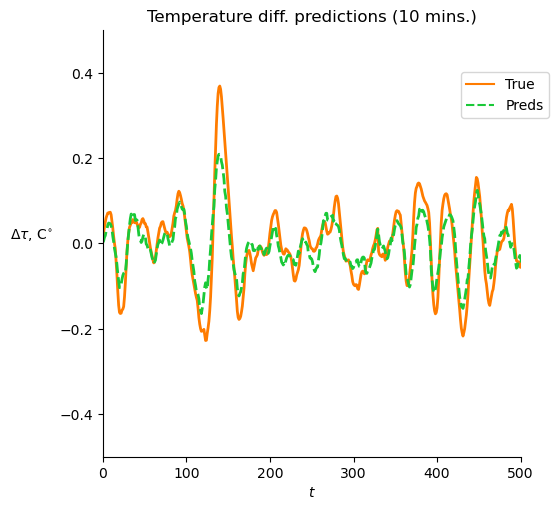

In [262]:
preds_df = pd.DataFrame(data=[targets_test / 10, np.squeeze(preds) / 10]).T
preds_df.columns = ['True', 'Preds']

ax = sns.relplot(
    data=preds_df,
    kind='line',
    palette=sns.color_palette('bright')[1:3],
    linewidth=2.0,
    markers=False,
    dashes=True
)

# ax.set_xticklabels(step=2)
sns.move_legend(ax, loc='upper right', frameon=True, bbox_to_anchor=(0.9, 0.9))
plt.xlim(0, 500)
plt.ylim(-0.5, 0.5)
plt.xlabel('$t$')
plt.ylabel('$\Delta \\tau$, C$^{\circ}$', rotation=0, labelpad=20)
plt.title('Temperature diff. predictions (10 mins.)')
plt.savefig(plot_path + 'temp_diff_model_preds.png', bbox_inches='tight', dpi=200)
plt.show()

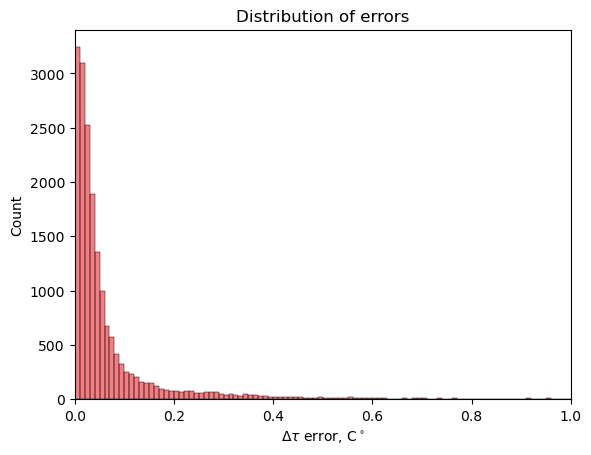

In [267]:
temp_diffs = np.abs(np.squeeze(preds / 10) - targets_test / 10)
# temp_diffs = (np.squeeze(preds) / 10) - (targets_test / 10)
# temp_diffs = (np.squeeze(preds) / 10) - (Y_test / 10)
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0.0, 1.0],
    kde=False,
    palette=sns.color_palette('bright')[3:4],
    legend=False
)

plt.title('Distribution of errors')
plt.xlim(0.0, 1.0)
# plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$ error, C$^\circ$')

plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

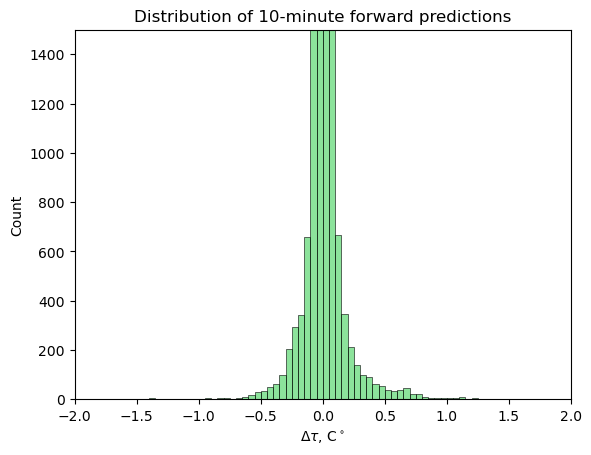

In [241]:
preds_df = pd.DataFrame(np.squeeze(preds) / 10)
# preds_df = pd.DataFrame(np.squeeze(preds) / 10)

sns.histplot(
    data=preds_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[2:3],
    legend=False
)

plt.title('Distribution of 10-minute forward predictions')
plt.xlim(-2.0, 2.0)
plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$, C$^\circ$')

plt.savefig(plot_path + 'temp_preds_dist.png', bbox_inches='tight', dpi=200)
plt.show()

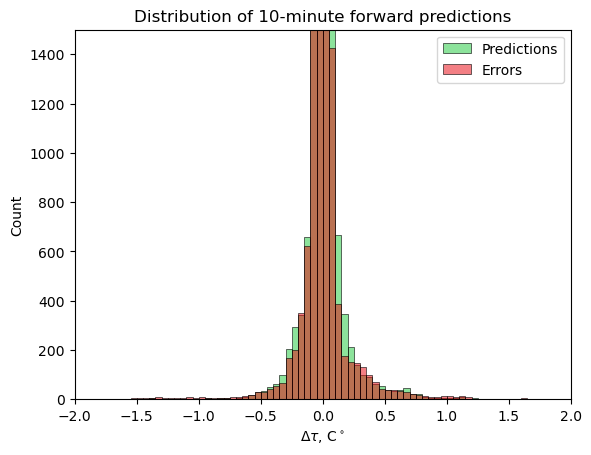

In [242]:
sns.histplot(
    data=preds_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[2:3],
    legend=False,
    label='Predictions'
)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.05,
    binrange=[-2.0, 2.0],
    kde=False,
    palette=sns.color_palette('bright')[3:4],
    legend=False,
    label='Errors',
)

plt.title('Distribution of 10-minute forward predictions')
plt.xlim(-2.0, 2.0)
plt.ylim(0, 1500)
plt.xlabel('$\Delta \\tau$, C$^\circ$')
plt.legend()

plt.savefig(plot_path + 'temp_both_dist.png', bbox_inches='tight', dpi=200)
plt.show()